In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 필요한 PONO, MS 모듈 정의 ---

class PONO(nn.Module):
    def __init__(self, eps=1e-5):
        super(PONO, self).__init__()
        self.eps = eps
    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = (x.var(dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x, mean, std

class MS(nn.Module):
    def __init__(self):
        super(MS, self).__init__()
    def forward(self, x, beta, gamma):
        return x * gamma + beta

# --- PONO와 MS가 적용된 Multi-Branch 모델 ---

class AODnet_MultiBranch_PONO(nn.Module):
    def __init__(self):
        super(AODnet_MultiBranch_PONO, self).__init__()
        print("[Model] Multi-Branch AODNet with PONO/MS 초기화 중...")

        # ----- K1 Branch (작은 스케일 특징 담당) -----
        self.k1_conv1 = nn.Conv2d(3, 3, kernel_size=1)
        self.k1_conv2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k1_conv3 = nn.Conv2d(6, 3, kernel_size=5, padding=2)

        # ----- K2 Branch (중간 스케일 특징 담당) -----
        self.k2_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k2_conv2 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k2_conv3 = nn.Conv2d(6, 3, kernel_size=7, padding=3)
        
        # ----- K3 Branch (큰 스케일 특징 담당) -----
        self.k3_conv1 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k3_conv2 = nn.Conv2d(3, 3, kernel_size=7, padding=3)
        self.k3_conv3 = nn.Conv2d(6, 3, kernel_size=9, padding=4)

        # ----- 3개 브랜치의 결과를 융합(Fusion)하는 레이어 -----
        self.fusion_conv = nn.Conv2d(9, 3, kernel_size=3, padding=1)
        
        # --- PONO와 MS 모듈 추가 ---
        self.pono = PONO()
        self.ms = MS()
        
        self.b = 1 # 대기 산란 모델의 상수

        print("[Model] Multi-Branch AODNet with PONO/MS 초기화 완료\n")


    def forward(self, x):
        # --- 각 브랜치의 첫 번째 Convolution 연산 ---
        x1_1 = F.relu(self.k1_conv1(x))
        x2_1 = F.relu(self.k2_conv1(x))
        x3_1 = F.relu(self.k3_conv1(x))

        # ★ 1. K3 브랜치의 초기 특징맵에서 스타일(평균, 표준편차) 추출
        # x3_1_norm: 정규화된 특징맵 (여기서는 사용하지 않음)
        # style_mean, style_std: K3의 전역 스타일 정보
        x3_1_norm, style_mean, style_std = self.pono(x3_1)

        # --- 각 브랜치의 나머지 연산 진행 ---
        # K1 Branch
        x1_2 = F.relu(self.k1_conv2(x1_1))
        k1_cat = torch.cat((x1_1, x1_2), dim=1)
        k1 = F.relu(self.k1_conv3(k1_cat))

        # K2 Branch
        x2_2 = F.relu(self.k2_conv2(x2_1))
        k2_cat = torch.cat((x2_1, x2_2), dim=1)
        k2 = F.relu(self.k2_conv3(k2_cat))

        # K3 Branch
        x3_2 = F.relu(self.k3_conv2(x3_1)) # 스타일 추출 후 원래의 x3_1을 계속 사용
        k3_cat = torch.cat((x3_1, x3_2), dim=1)
        k3 = F.relu(self.k3_conv3(k3_cat))
        
        # ★ 2. K1 브랜치의 결과물에 K3의 스타일을 주입하여 변조
        # beta=style_mean, gamma=style_std 로 스타일 정보를 전달
        k1_modulated = self.ms(k1, beta=style_mean, gamma=style_std)

        # --- Fusion 단계 ---
        # ★ 3. 스타일이 변조된 k1을 사용하여 Fusion
        k_fused = torch.cat((k1_modulated, k2, k3), dim=1)
        k_final = F.relu(self.fusion_conv(k_fused))

        # --- AOD-Net 복원 공식 적용 ---
        output = k_final * x - k_final + self.b
        return F.relu(output)

In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = AODnet_MultiBranch_PONO()
print_model_summary(model, "AODnet")

[Model] Multi-Branch AODNet with PONO/MS 초기화 중...
[Model] Multi-Branch AODNet with PONO/MS 초기화 완료

========== AODnet Summary ==========
Layer: k1_conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: k1_conv1.bias,  Shape: torch.Size([3])
Layer: k1_conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k1_conv2.bias,  Shape: torch.Size([3])
Layer: k1_conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: k1_conv3.bias,  Shape: torch.Size([3])
Layer: k2_conv1.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k2_conv1.bias,  Shape: torch.Size([3])
Layer: k2_conv2.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k2_conv2.bias,  Shape: torch.Size([3])
Layer: k2_conv3.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: k2_conv3.bias,  Shape: torch.Size([3])
Layer: k3_conv1.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k3_conv1.bias,  Shape: torch.Size([3])
Layer: k3_conv2.weight,  Shape: torch.Size([3, 3, 7, 7])
Layer: k3_conv2.bias,  Shape: torch.Size([3])
Layer: k3_conv3.weight,  Shape: torch.Si

In [4]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [5]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/TBaodNet4"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [6]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((240, 360)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 240, 360])
GT 이미지 텐서 모양: torch.Size([3, 240, 360])


In [7]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet_MultiBranch_PONO().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] Multi-Branch AODNet with PONO/MS 초기화 중...
[Model] Multi-Branch AODNet with PONO/MS 초기화 완료

Model: AODnet_MultiBranch_PONO


In [ ]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s, loss=0.0396]


Epoch [1/100], Train Loss: 0.132750, Val Loss: 0.032284
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_1.pth (Val Loss: 0.032284) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s, loss=0.0141]


Epoch [2/100], Train Loss: 0.026863, Val Loss: 0.024898
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_2.pth (Val Loss: 0.024898) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.0132]


Epoch [3/100], Train Loss: 0.024954, Val Loss: 0.024556
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_3.pth (Val Loss: 0.024556) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.95it/s, loss=0.014] 


Epoch [4/100], Train Loss: 0.024772, Val Loss: 0.024143
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_4.pth (Val Loss: 0.024143) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s, loss=0.0136]


Epoch [5/100], Train Loss: 0.024540, Val Loss: 0.023933
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_5.pth (Val Loss: 0.023933) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0124]


Epoch [6/100], Train Loss: 0.024339, Val Loss: 0.023809
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_6.pth (Val Loss: 0.023809) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s, loss=0.0135]


Epoch [7/100], Train Loss: 0.024140, Val Loss: 0.023652
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_7.pth (Val Loss: 0.023652) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0123]


Epoch [8/100], Train Loss: 0.023919, Val Loss: 0.023330
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_8.pth (Val Loss: 0.023330) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.0121]


Epoch [9/100], Train Loss: 0.023755, Val Loss: 0.023145
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_9.pth (Val Loss: 0.023145) *****



Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.0131]


Epoch [10/100], Train Loss: 0.023586, Val Loss: 0.023135
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_10.pth (Val Loss: 0.023135) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.0126]


Epoch [11/100], Train Loss: 0.023470, Val Loss: 0.022919
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_11.pth (Val Loss: 0.022919) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.0109] 


Epoch [12/100], Train Loss: 0.023231, Val Loss: 0.022800
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_12.pth (Val Loss: 0.022800) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0111] 


Epoch [13/100], Train Loss: 0.023174, Val Loss: 0.022587
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_13.pth (Val Loss: 0.022587) *****



Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s, loss=0.0117]


Epoch [14/100], Train Loss: 0.022996, Val Loss: 0.022477
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_14.pth (Val Loss: 0.022477) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.0101] 


Epoch [15/100], Train Loss: 0.022817, Val Loss: 0.022674


Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.01]   


Epoch [16/100], Train Loss: 0.022893, Val Loss: 0.022802


Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.0113] 


Epoch [17/100], Train Loss: 0.022684, Val Loss: 0.022240
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_17.pth (Val Loss: 0.022240) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0107] 


Epoch [18/100], Train Loss: 0.022689, Val Loss: 0.022134
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_18.pth (Val Loss: 0.022134) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0124]


Epoch [19/100], Train Loss: 0.022648, Val Loss: 0.022617


Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.0115]


Epoch [20/100], Train Loss: 0.022583, Val Loss: 0.022245


Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0107] 


Epoch [21/100], Train Loss: 0.022394, Val Loss: 0.021961
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_21.pth (Val Loss: 0.021961) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.0102] 


Epoch [22/100], Train Loss: 0.022429, Val Loss: 0.021836
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_22.pth (Val Loss: 0.021836) *****



Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.0104] 


Epoch [23/100], Train Loss: 0.022199, Val Loss: 0.021806
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_23.pth (Val Loss: 0.021806) *****



Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, loss=0.0107] 


Epoch [24/100], Train Loss: 0.022226, Val Loss: 0.021858


Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s, loss=0.00938]


Epoch [25/100], Train Loss: 0.022177, Val Loss: 0.021891


Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s, loss=0.00976]


Epoch [26/100], Train Loss: 0.022030, Val Loss: 0.021650
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_26.pth (Val Loss: 0.021650) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s, loss=0.00997]


Epoch [27/100], Train Loss: 0.022027, Val Loss: 0.021589
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_27.pth (Val Loss: 0.021589) *****



Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s, loss=0.00976]


Epoch [28/100], Train Loss: 0.022016, Val Loss: 0.021621


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s, loss=0.00989]


Epoch [29/100], Train Loss: 0.021983, Val Loss: 0.021559
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_29.pth (Val Loss: 0.021559) *****



Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s, loss=0.00916]


Epoch [30/100], Train Loss: 0.021976, Val Loss: 0.021617


Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.76it/s, loss=0.0092] 


Epoch [31/100], Train Loss: 0.021908, Val Loss: 0.021590


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s, loss=0.00906]


Epoch [32/100], Train Loss: 0.021934, Val Loss: 0.021599


Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.70it/s, loss=0.00937]


Epoch [33/100], Train Loss: 0.021895, Val Loss: 0.021448
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_33.pth (Val Loss: 0.021448) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.64it/s, loss=0.00913]


Epoch [34/100], Train Loss: 0.021866, Val Loss: 0.021569


Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s, loss=0.00972]


Epoch [35/100], Train Loss: 0.021892, Val Loss: 0.021361
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_35.pth (Val Loss: 0.021361) *****



Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s, loss=0.0107] 


Epoch [36/100], Train Loss: 0.021776, Val Loss: 0.021673


Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.69it/s, loss=0.00965]


Epoch [37/100], Train Loss: 0.021836, Val Loss: 0.021324
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_37.pth (Val Loss: 0.021324) *****



Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s, loss=0.00967]


Epoch [38/100], Train Loss: 0.021736, Val Loss: 0.021288
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_38.pth (Val Loss: 0.021288) *****



Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.00924]


Epoch [39/100], Train Loss: 0.021753, Val Loss: 0.021265
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_39.pth (Val Loss: 0.021265) *****



Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.0108]


Epoch [40/100], Train Loss: 0.021673, Val Loss: 0.021578


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s, loss=0.00924]


Epoch [41/100], Train Loss: 0.021691, Val Loss: 0.021228
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_41.pth (Val Loss: 0.021228) *****



Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s, loss=0.00957]


Epoch [42/100], Train Loss: 0.021660, Val Loss: 0.021300


Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.00911]


Epoch [43/100], Train Loss: 0.021648, Val Loss: 0.021237


Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s, loss=0.00906]


Epoch [44/100], Train Loss: 0.021546, Val Loss: 0.021208
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_44.pth (Val Loss: 0.021208) *****



Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.0101] 


Epoch [45/100], Train Loss: 0.021665, Val Loss: 0.021309


Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.0088] 


Epoch [46/100], Train Loss: 0.021618, Val Loss: 0.021287


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.0101] 


Epoch [47/100], Train Loss: 0.021618, Val Loss: 0.021340


Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.00894]


Epoch [48/100], Train Loss: 0.021584, Val Loss: 0.021157
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_48.pth (Val Loss: 0.021157) *****



Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.00874]


Epoch [49/100], Train Loss: 0.021550, Val Loss: 0.021247


Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.88it/s, loss=0.00933]


Epoch [50/100], Train Loss: 0.021534, Val Loss: 0.021085
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_50.pth (Val Loss: 0.021085) *****



Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00895]


Epoch [51/100], Train Loss: 0.021513, Val Loss: 0.021189


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.00884]


Epoch [52/100], Train Loss: 0.021525, Val Loss: 0.021129


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.33it/s, loss=0.00933]


Epoch [53/100], Train Loss: 0.021433, Val Loss: 0.021085


Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s, loss=0.00927]


Epoch [54/100], Train Loss: 0.021499, Val Loss: 0.021060
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_54.pth (Val Loss: 0.021060) *****



Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.00892]


Epoch [55/100], Train Loss: 0.021499, Val Loss: 0.021068


Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.00992]


Epoch [56/100], Train Loss: 0.021467, Val Loss: 0.021269


Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s, loss=0.00963]


Epoch [57/100], Train Loss: 0.021480, Val Loss: 0.021095


Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s, loss=0.0101] 


Epoch [58/100], Train Loss: 0.021418, Val Loss: 0.021191


Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.32it/s, loss=0.0108]


Epoch [59/100], Train Loss: 0.021440, Val Loss: 0.021430


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s, loss=0.00915]


Epoch [60/100], Train Loss: 0.021373, Val Loss: 0.020972
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_60.pth (Val Loss: 0.020972) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s, loss=0.00885]


Epoch [61/100], Train Loss: 0.021413, Val Loss: 0.021085


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s, loss=0.0103] 


Epoch [62/100], Train Loss: 0.021376, Val Loss: 0.021235


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.00907]


Epoch [63/100], Train Loss: 0.021446, Val Loss: 0.020929
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_63.pth (Val Loss: 0.020929) *****



Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.00902]


Epoch [64/100], Train Loss: 0.021414, Val Loss: 0.020939


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s, loss=0.00972]


Epoch [65/100], Train Loss: 0.021280, Val Loss: 0.021064


Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, loss=0.01]   


Epoch [66/100], Train Loss: 0.021403, Val Loss: 0.021048


Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s, loss=0.00894]


Epoch [67/100], Train Loss: 0.021400, Val Loss: 0.020955


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.03it/s, loss=0.00911]


Epoch [68/100], Train Loss: 0.021368, Val Loss: 0.020847
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_68.pth (Val Loss: 0.020847) *****



Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.01]   


Epoch [69/100], Train Loss: 0.021359, Val Loss: 0.020984


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s, loss=0.00893]


Epoch [70/100], Train Loss: 0.021243, Val Loss: 0.020851


Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.00954]


Epoch [71/100], Train Loss: 0.021323, Val Loss: 0.020880


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.00834]


Epoch [72/100], Train Loss: 0.021243, Val Loss: 0.021446


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s, loss=0.00941]


Epoch [73/100], Train Loss: 0.021235, Val Loss: 0.020769
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_73.pth (Val Loss: 0.020769) *****



Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.00831]


Epoch [74/100], Train Loss: 0.021093, Val Loss: 0.021259


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.00947]


Epoch [75/100], Train Loss: 0.021258, Val Loss: 0.020788


Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.00965]


Epoch [76/100], Train Loss: 0.021124, Val Loss: 0.020845


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.0089] 


Epoch [77/100], Train Loss: 0.021168, Val Loss: 0.020723
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_77.pth (Val Loss: 0.020723) *****



Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.0097] 


Epoch [78/100], Train Loss: 0.021148, Val Loss: 0.020776


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s, loss=0.0102] 


Epoch [79/100], Train Loss: 0.021088, Val Loss: 0.021007


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s, loss=0.0105] 


Epoch [80/100], Train Loss: 0.021037, Val Loss: 0.021225


Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.00891]


Epoch [81/100], Train Loss: 0.021052, Val Loss: 0.020618
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_81.pth (Val Loss: 0.020618) *****



Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s, loss=0.00971]


Epoch [82/100], Train Loss: 0.021034, Val Loss: 0.020797


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s, loss=0.00847]


Epoch [83/100], Train Loss: 0.021009, Val Loss: 0.020783


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.0104]


Epoch [84/100], Train Loss: 0.020990, Val Loss: 0.021169


Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.0103] 


Epoch [85/100], Train Loss: 0.021004, Val Loss: 0.021175


Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.00961]


Epoch [86/100], Train Loss: 0.021027, Val Loss: 0.020676


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.0101] 


Epoch [87/100], Train Loss: 0.020950, Val Loss: 0.020937


Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.00853]


Epoch [88/100], Train Loss: 0.020877, Val Loss: 0.020547
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_88.pth (Val Loss: 0.020547) *****



Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, loss=0.0087] 


Epoch [89/100], Train Loss: 0.020929, Val Loss: 0.020477
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_89.pth (Val Loss: 0.020477) *****



Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.00864]


Epoch [90/100], Train Loss: 0.020845, Val Loss: 0.020480


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00863]


Epoch [91/100], Train Loss: 0.020836, Val Loss: 0.020456
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_91.pth (Val Loss: 0.020456) *****



Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s, loss=0.00823]


Epoch [92/100], Train Loss: 0.020867, Val Loss: 0.020663


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, loss=0.00965]


Epoch [93/100], Train Loss: 0.020943, Val Loss: 0.020602


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, loss=0.0087] 


Epoch [94/100], Train Loss: 0.020878, Val Loss: 0.020405
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_94.pth (Val Loss: 0.020405) *****



Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s, loss=0.00905]


Epoch [95/100], Train Loss: 0.020906, Val Loss: 0.020460


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s, loss=0.0089] 


Epoch [96/100], Train Loss: 0.020834, Val Loss: 0.020395
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_96.pth (Val Loss: 0.020395) *****



Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.00875]


Epoch [97/100], Train Loss: 0.020811, Val Loss: 0.020389
***** Best model saved to ./pt/TBaodNet4\best_model_epoch_97.pth (Val Loss: 0.020389) *****



Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.00972]


Epoch [98/100], Train Loss: 0.020797, Val Loss: 0.020608


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.00863]


Epoch [99/100], Train Loss: 0.020846, Val Loss: 0.020390


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.00911]

Epoch [100/100], Train Loss: 0.020805, Val Loss: 0.020408

===== 모든 학습이 완료되었습니다! =====


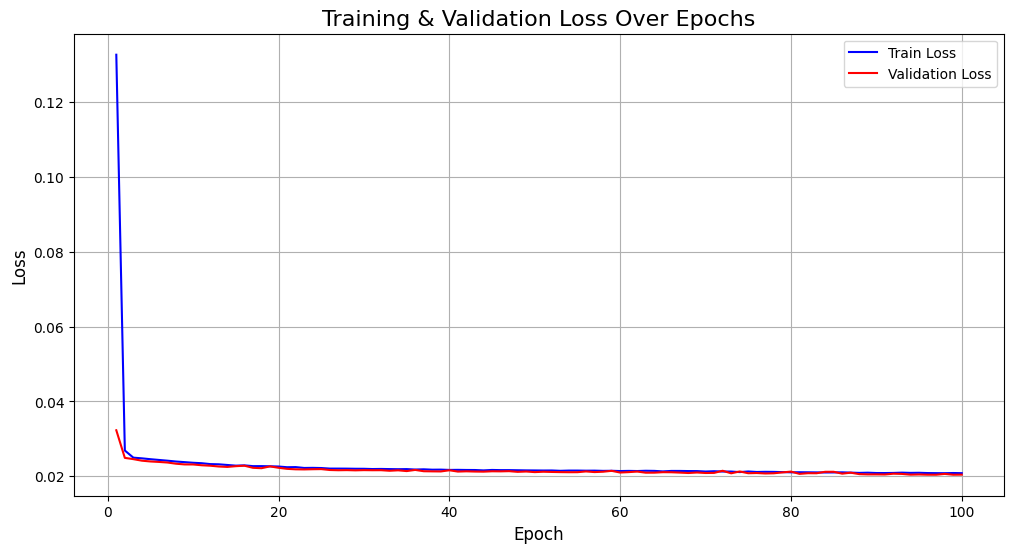

In [9]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [11]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/TBaodNet4/best_model_epoch_97.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch_PONO().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] Multi-Branch AODNet with PONO/MS 초기화 중...
[Model] Multi-Branch AODNet with PONO/MS 초기화 완료


===== 'pt/TBaodNet4/best_model_epoch_97.pth' 모델 성능 평가 시작 =====


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 127/127 [00:22<00:00,  5.72it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 18.3516 dB
테스트 데이터셋 평균 SSIM: 0.7103


[Model] Multi-Branch AODNet with PONO/MS 초기화 중...
[Model] Multi-Branch AODNet with PONO/MS 초기화 완료

이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


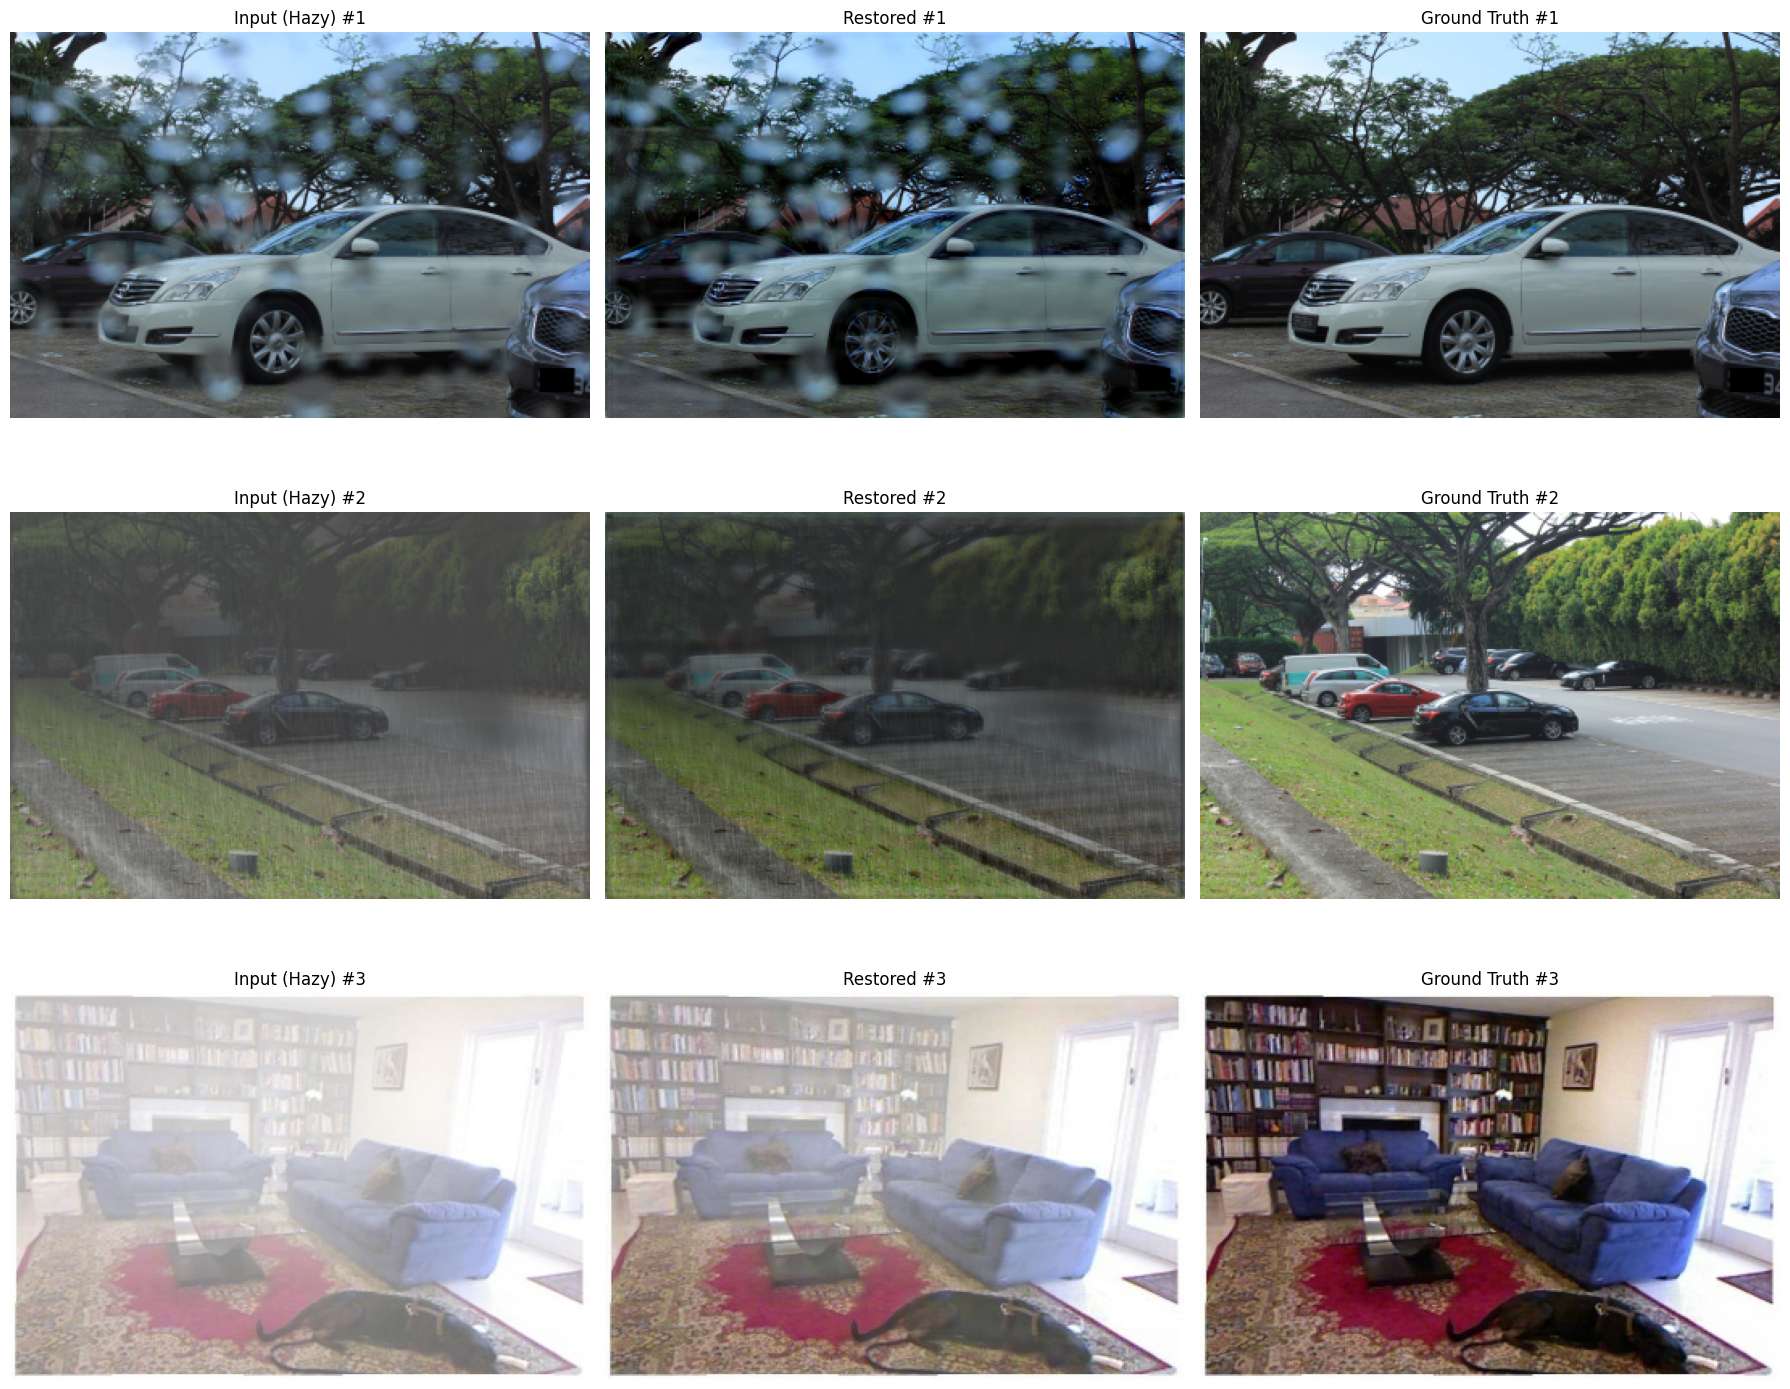


이미지 복원 및 비교 완료!


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/TBaodNet4/best_model_epoch_97.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch_PONO().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [13]:
# 객체 탐지 추가 yolo 사용
import os
import sys
import time
from pathlib import Path
from flask import Flask, request, jsonify
from flask_socketio import SocketIO, emit
import cv2
import numpy as np
from PIL import Image 
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
from torchvision import transforms


class YOLODetector:
    def __init__(self, weights_path='pt/yolov5s.pt', conf_thres=0.25, img_size=640, device='cpu'):
        self.device = device
        print(f"💡 YOLODetector 사용 장치: {self.device}")

        if not os.path.exists(weights_path):
            print(f"🚨 경고: YOLO 가중치 파일이 로컬에 없습니다: {weights_path}")
            print("torch.hub에서 표준 모델 이름으로 다운로드 시도합니다.")
            weights_path = os.path.basename(weights_path)
            if not weights_path.endswith('.pt'):
                pass 
            else: 
                print(f"🚨 오류: YOLO 가중치 파일({weights_path})이 로컬에 없으며 표준 모델 이름이 아닐 수 있습니다.")

        try:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=False)
            self.model.to(self.device)
            self.model.eval()
            self.model.conf = conf_thres
            self.model.iou = 0.45
            self.model.imgsz = img_size
            print(f"✅ YOLO 모델 로딩 완료: {weights_path}, img_size={self.model.imgsz}")
        except Exception as e:
            print(f"❌ YOLO 모델 로딩 실패: {e}")
            self.model = None

    def detect_array(self, img_array):
        if self.model is None:
            print("🚨 YOLO 모델이 로딩되지 않았습니다. 객체 검출 건너뜜.")
            # 메인 스크립트와 호환성을 위해 원본 이미지를 그대로 반환
            return img_array

        if img_array is None or img_array.size == 0:
            print("🚨 detect_array: 유효하지 않은 입력 이미지입니다.")
            return None

        try:
            # ===================== ★★★ 핵심 수정 파트 ★★★ =====================
            # 1. 모델 실행 결과가 튜플일 수 있으므로 안전하게 처리
            model_output = self.model(img_array)
            results = model_output[0] if isinstance(model_output, tuple) else model_output
            
            # 2. 바운딩 박스가 그려진 이미지만 반환하도록 수정
            annotated_img = results.render()[0] # render() 결과는 list이므로 [0]으로 이미지를 꺼냄
            return annotated_img
            # =======================================================================
        except Exception as e:
            print(f"❌ YOLO detect_array 중 오류 발생: {e}")
            # 에러 발생 시에도 원본 이미지를 반환하여 흐름이 끊기지 않도록 함
            return img_array

    def extract_detections(self, results):
        detections = []
        if results is not None and hasattr(results, 'xyxy') and len(results.xyxy) > 0:
            for *xyxy, conf, cls in results.xyxy[0]:
                detections.append({
                    'bbox': [float(x.item()) for x in xyxy],
                    'confidence': float(conf.item()),
                    'class_id': int(cls.item()),
                    'class_name': self.model.names[int(cls.item())] if self.model and hasattr(self.model, 'names') else f'class_{int(cls.item())}'
                })
        return detections

In [15]:
# =========================================================================
# 1. 라이브러리 임포트 및 환경 설정
# =========================================================================
import os
from glob import glob
from typing import Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.models import VGG16_Weights
import matplotlib.pyplot as plt
import cv2

# (수정) IPython Notebook 환경에서 플롯을 셀 내부에 바로 표시하기 위한 설정
%matplotlib inline 

# --- 사용자 정의 모델 파일 임포트 ---
# 'model' 디렉토리에 'derainhaze.py' 파일이 있어야 합니다.
import model.derainhaze as mod

# =========================================================================
# 2. YOLO 탐지기 클래스 정의
# =========================================================================
# 이 클래스는 단일 셀 내에서 실행되므로, 정의 부분이 코드에 포함되어야 합니다.
class YOLODetector:
    def __init__(self, weights_path='yolov5s.pt', device='cpu', img_size=360):
        """
        YOLOv5 모델을 로드하고 초기화합니다.
        'yolov5s.pt' 파일이 없다면 처음 실행 시 자동으로 다운로드됩니다.
        """
        try:
            self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)
            self.model.to(device)
            self.img_size = img_size
            self.device = device
            print("YOLOv5 detector loaded successfully.")
        except Exception as e:
            print(f"Error loading YOLOv5 model: {e}")
            print("Please ensure you have an internet connection for the first-time setup,")
            print("or that 'yolov5s.pt' is in the correct directory.")
            raise

    def detect_array(self, np_image):
        """NumPy 배열 형태의 이미지에서 객체를 탐지하고 바운딩 박스를 그립니다."""
        self.model.eval()
        with torch.no_grad():
            # 모델은 BGR이 아닌 RGB 순서의 이미지를 기대합니다.
            results = self.model(np_image, size=self.img_size)
        
        # 탐지 결과를 원본 이미지에 렌더링 (바운딩 박스 그리기)
        rendered_image = results.render()[0]
        return rendered_image

# =========================================================================
# 3. 메인 코드 실행
# =========================================================================

# --- 기본 설정 ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- 안개 제거 모델 로딩 ---
print("Loading de-hazing model...")
MODEL_WEIGHTS_PATH = "pt/TBaodNet4/best_model_epoch_97.pth"
evaluation_model = AODnet_MultiBranch_PONO().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# --- YOLO 탐지기 인스턴스 생성 ---
# YOLOv5 가중치 파일('yolov5s.pt')이 코드와 같은 디렉토리에 있어야 합니다.
global_yolo_detector = YOLODetector(weights_path='yolov5s.pt', device=str(DEVICE), img_size=360)

# --- 이미지 경로 및 설정 ---
HAZY_IMAGE_PATHS = [
    "testimage2/test3.jpg", "testimage2/test5.jpg", "testimage2/test4.jpg", "testimage2/test7.jpg"
]
TARGET_IMAGE_SIZE = (360, 240)
results = []

print("\nStarting image restoration and detection...")

# --- 메인 처리 루프 ---
for hazy_path in HAZY_IMAGE_PATHS:
    try:
        # 1. 이미지 로딩 및 전처리
        hazy_pil = Image.open(hazy_path).convert('RGB').resize(TARGET_IMAGE_SIZE)
        hazy_np_rgb = np.array(hazy_pil)
        hazy_tensor = torch.from_numpy(hazy_np_rgb).permute(2, 0, 1).float().unsqueeze(0) / 255.0
        hazy_tensor = hazy_tensor.to(DEVICE)

        # 2. 모델 추론 (안개/헤이즈 제거)
        with torch.no_grad():
            output = evaluation_model(hazy_tensor)
            restored_tensor = output[0] if isinstance(output, tuple) else output
        
        # 3. 후처리 및 YOLO 탐지
        min_val, max_val = torch.min(restored_tensor), torch.max(restored_tensor)
        normalized_tensor = (restored_tensor - min_val) / (max_val - min_val + 1e-6)

        restored_np_rgb = normalized_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        restored_np_uint8 = (restored_np_rgb * 255).astype(np.uint8)
        
        annotated_np = global_yolo_detector.detect_array(restored_np_uint8)
        annotated_pil = Image.fromarray(annotated_np)

        # 4. 시각화를 위해 결과 저장
        results.append({
            'hazy': hazy_pil,
            'restored_annotated': annotated_pil 
        })
        
        print(f"  - '{hazy_path}' processing complete.")

    except FileNotFoundError:
        print(f"  - Error: Could not find file '{hazy_path}'. Please check the path.")
    except Exception as e:
        print(f"  - An error occurred while processing '{hazy_path}': {e}")

# =========================================================================
# 4. 결과 시각화
# =========================================================================
if results:
    num_images = len(results)
    plt.figure(figsize=(10, 4 * num_images)) 

    for i, res in enumerate(results):
        # 원본 (Hazy) 이미지
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(res['hazy'])
        plt.title(f'Input #{i+1}')
        plt.axis('off')

        # 복원 및 탐지된 이미지
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(res['restored_annotated'])
        plt.title(f'Restored & Detected #{i+1}')
        plt.axis('off')

    plt.tight_layout(pad=2.0)
    save_path = "comparison_result_single_model.png"
    plt.savefig(save_path)
    print(f"\nPlot saved to '{save_path}'")
    
    # 노트북에서는 plt.show()가 셀의 마지막에 자동으로 호출되는 것과 비슷하게 동작하지만,
    # 명시적으로 호출하여 플롯을 깔끔하게 마무리합니다.
    plt.show()
    print("\n✨ Image restoration and comparison complete! ✨")
else:
    print("\nNo images were processed successfully. Nothing to display.")

Using device: cuda
Loading de-hazing model...
[Model] Multi-Branch AODNet with PONO/MS 초기화 중...
[Model] Multi-Branch AODNet with PONO/MS 초기화 완료



Using cache found in C:\Users\zmffk/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-7 Python-3.9.13 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\zmffk/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


YOLOv5 detector loaded successfully.

Starting image restoration and detection...
  - 'testimage2/test3.jpg' processing complete.
  - 'testimage2/test5.jpg' processing complete.
  - 'testimage2/test4.jpg' processing complete.


C:\Users\zmffk/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\zmffk/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\zmffk/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  - 'testimage2/test7.jpg' processing complete.

Plot saved to 'comparison_result_single_model.png'

✨ Image restoration and comparison complete! ✨
